# Plotting of experimental data

- 2a: plotting of distribution
- 

In [1]:
import sys, os
import glob 
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import collections
import builtins
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as spi
from scipy.integrate import odeint #this is the module to solve ODEs

import met_brewer

%matplotlib inline
# Load the scipy module/
import scipy.stats 
import json

import csv
from collections import defaultdict
from pprint import pprint

################################
#load information of species to include
#################################
#load species information for all characterized species
speciesinformation=pd.read_csv("data_hplc/species_properties.csv",skiprows=1)
display(speciesinformation.head())


from ete3 import Tree, TreeStyle, TextFace, add_face_to_node
import plot_eteTree 
#adjusted from https://gist.github.com/jolespin/5d90deff552138d73de7ed4bdd9ac57a


,species_HPLCname,species,new_species,species.1,species_short,new_genus,genus,new_family,family,new_order,order,new_class,class,new_phylum,phylum
0,B.vulgatus,Phocaeicola vulgatus,Phocaeicola vulgatus,Bacteroides vulgatus,B. vulgatus,Phocaeicola,Phocaeicola,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes
1,B.fragilis,Bacteroides fragilis,Bacteroides fragilis,Bacteroides fragilis,B. fragilis,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes
2,B.ovatus,Bacteroides ovatus,Bacteroides ovatus,Bacteroides ovatus,B. ovatus,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes
3,B.theta,Bacteroides thetaiotaomicron,Bacteroides thetaiotaomicron,Bacteroides thetaiotaomicron,B. theta,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes
4,P.copri,Prevotella copri,Prevotella copri,Prevotella copri,P. copri,Prevotella,Prevotella,Prevotellaceae,Prevotellaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes


# Load general files and generate tree

## Note: This uses the taxonomic abundance tables caliulatioed in subfolder microbiota_composition. To decide if all or only healthy samples should be considered run the script in the folder first and make your selection there.


In [2]:
############################
#plotting options for tree
##########################
phyla_colors=["r","b","m","orange","brown"] 
phyla=['Bacteroidetes', 'Firmicutes', 'Actinobacteria', 'Proteobacteria']

#define which study to use for abundance data
study="HMP_2019_ibdmdb"



################################
#load abundance information (from analysis of metagenomics data"
# ! modify here if other studies should be included
################################
abundanceinformation=[]
taxa_levellist=[]
taxa_levellistC=[]
for level in ["phylum","class","order","family","genus","species"]:
    taxa_levellist.append([])
    taxa_levellistC.append([])
    abundanceinformation.append(pd.read_csv("../microbiota_composition/avabundance_"+level+".csv",skiprows=0,index_col=0,))

all_species_list=[]
all_species_list_short=[]
#################################
#generate Newick tree
################################
branchdistance=":2" #distance between branches
branchdistance_species=":0.3" #distance of lead (last name)

#start analysis
branchdistance_number=float(branchdistance[1:])
phyla=speciesinformation["phylum"].unique()
newick="("
cP=-1

#go through each taxonomic level
for phylum in phyla:
    taxa_levellist[0].append(phylum)  
    cP=cP+1
    taxa_levellistC[0].append(phyla_colors[cP])
    select=speciesinformation.loc[speciesinformation["phylum"]==phylum]
    classes=select["class"].unique()
    
    if cP==0:
            newick=newick+"("
    else:
            newick=newick+",("
    cI=-1    
    for classc in classes:
        taxa_levellist[1].append(classc)
        taxa_levellistC[1].append(phyla_colors[cP])
        cI=cI+1
        select1=select.loc[select["class"]==classc]
        if cI==0:
            newick=newick+"("
        else:
            newick=newick+",("
        orders=select1["order"].unique()
        oI= -1
        for order in orders:
            taxa_levellist[2].append(order)
            taxa_levellistC[2].append(phyla_colors[cP])
            oI=oI+1
            select2=select1.loc[select1["order"]==order]
            if oI==0:
                newick=newick+"("
            else:
                newick=newick+",("
            families=select2["family"].unique()
            fI=-1
            for family in families:
                taxa_levellist[3].append(family)
                taxa_levellistC[3].append(phyla_colors[cP])
                fI=fI+1
                select3=select2.loc[select2["family"]==family]
                genus=select3["genus"].unique()
                if fI==0:
                    newick=newick+"("
                else:
                    newick=newick+",("

                gI=-1
                for genus in genus:
                    taxa_levellist[4].append(genus)
                    taxa_levellistC[4].append(phyla_colors[cP])
                    gI=gI+1
                    select4=select3.loc[select3["genus"]==genus]
                    species=select4["species"].unique()
                    if gI==0:
                        newick=newick+"("
                    else:
                        newick=newick+",("
                    spc=-1
                    for speciesc in species:
                            taxa_levellist[5].append(speciesc)
                            taxa_levellistC[5].append(phyla_colors[cP])
                            spc=spc+1
                            if spc>0:
                                newick=newick+","
                            select5=select4.loc[select4["species"]==speciesc]
                            all_species_list.append(speciesc)
                            newick= newick+speciesc+branchdistance_species
                    newick=newick+")"+genus+branchdistance
                newick=newick+")"+family+branchdistance
            newick=newick+")"+order+branchdistance
        newick=newick+")"+classc+branchdistance
    newick=newick+")"+str(phylum)+branchdistance  
newick=newick+");"

#save tree
text_file = open("newick.txt", "w")
n = text_file.write(newick)
text_file.close()

print(all_species_list)


#####################
#for different nodes of tree get abundance lvele
######################
    

lc=-1
abundancevalues=[]
for level in ["phylum","class","order","family","genus","species"]:
    abundancevalues.append([])
    lc=lc+1
    print(taxa_levellist[lc])
    for taxidentifier in taxa_levellist[lc]:
        #print(taxidentifier)
        abundancevalues[-1].append(abundanceinformation[lc].at[taxidentifier,study])


#generate list with abundance for all taxonomic levels
alltaxonomicnames=[]
alltaxonomiccolors=[] #color (currently based on phyla)
alltaxonomiccolors_phylum=[] #color (phyla in color rest black)
taxonomiclevel=[]

alltaxonomicabundances=[]
abundancevalues_sum=[]
lc=-1
for level in ["phylum","class","order","family","genus","species"]:
    lc=lc+1
    #colors for taxonomic names
    #option 1: only phylum in phylum color, others black
    #if level=="phylum":
    #    alltaxonomiccolors_phylum=alltaxonomiccolors_phylum+taxa_levellistC[lc]
    #else:
    #    alltaxonomiccolors_phylum=alltaxonomiccolors_phylum+["k"]*len(taxa_levellist[lc])
    #option 2: set all names according to phylum:
    alltaxonomiccolors_phylum=alltaxonomiccolors_phylum+taxa_levellistC[lc]
    taxonomiclevel=taxonomiclevel+[level]*len(taxa_levellist[lc])

   
    alltaxonomicnames=alltaxonomicnames+taxa_levellist[lc]
    alltaxonomiccolors=alltaxonomiccolors+taxa_levellistC[lc]
    abundancevalues_sum.append(sum(abundancevalues[lc]))
    alltaxonomicabundances=alltaxonomicabundances+abundancevalues[lc]

#for easier handling, generate dataframe with all information
data_abundancec=pd.DataFrame(list(zip(alltaxonomicnames, alltaxonomicabundances, alltaxonomiccolors,alltaxonomiccolors_phylum,taxonomiclevel)))
data_abundancec.columns=["taxidentifier","abundance","color","color_phylum","tax_level"]
data_abundancec.set_index("taxidentifier",inplace=True)
print("sum of abundance")
print(abundancevalues_sum)




#add short and alternamtive names according to 
for iter, row in data_abundancec.iterrows():
    levelc=row["tax_level"]
    taxind=iter
    curinfo=speciesinformation.loc[speciesinformation[levelc]==iter]
    if levelc=="species":
        shortn=curinfo[level+"_short"]
        data_abundancec.at[iter,"short_name"]=shortn.iloc[0]
    shortn=curinfo["new_"+levelc]
    if (shortn.shape[0]>1) and (levelc=="species"):
        error
    data_abundancec.at[iter,"new_name"]=shortn.iloc[0]

display(data_abundancec.head(15))
#consistency check, taxonomic identifiers should be unique
if len(alltaxonomicnames) != len(set(alltaxonomicnames)):
    print("Error: non unique used of taxonomic identifiers")
    print([item for item, count in collections.Counter(alltaxonomicnames).items() if count > 1])
    error

############
#generate ete3 tree from Newick tree
############

t = Tree(newick, format=1)
ts = TreeStyle()
ts.show_leaf_name = False

############
#ad properties to tree branches
#############

all_species_list_short=[]
for leaf in t.traverse():
    nameleaf=leaf.name
    if len(nameleaf)>0:
        abundancec=str(round(data_abundancec.at[nameleaf,"abundance"],1))+"%"

        
        color=data_abundancec.at[nameleaf,"color"] #color for lines
        color_phylum=data_abundancec.at[nameleaf,"color_phylum"] #color for taxonomic names
        new_name=data_abundancec.at[nameleaf,"new_name"]
        short_name=data_abundancec.at[nameleaf,"short_name"]
        if short_name != "nan":
            all_species_list_short.append(short_name)
        #print(nameleaf)
        #print(abundancec)
        leaf.add_features(abundance=abundancec)
        leaf.add_features(new_name=new_name)
        leaf.add_features(short_name=short_name)
        leaf.add_features(color=color_phylum)
        leaf.img_style['hz_line_color'] = color
        leaf.img_style['vt_line_color'] = color
    else:
        leaf.add_features(abundance="")
        leaf.add_features(abundance="")
        leaf.add_features(new_name="")
        leaf.add_features(short_name="")
        leaf.add_features(color="k")
        leaf.img_style['hz_line_color'] = "k"
        leaf.img_style['vt_line_color'] = "k"

        
    leaf.img_style['hz_line_width']=2
    leaf.img_style['vt_line_width']=2
    leaf.img_style['fgcolor']='#000000'

print(all_species_list_short)


['Phocaeicola vulgatus', 'Bacteroides fragilis', 'Bacteroides ovatus', 'Bacteroides thetaiotaomicron', 'Bacteroides finegoldii', 'Bacteroides uniformis', 'Prevotella copri', 'Parabacteroides distasonis', 'Eubacterium rectale', 'Roseburia intestinalis', 'Faecalibacterium prausnitzii', 'Ruminococcus bromii', 'Bifidobacterium longum', 'Bifidobacterium adolescentis', 'Collinsella aerofaciens', 'Escherichia coli']
['Bacteroidetes', 'Firmicutes', 'Actinobacteria', 'Proteobacteria', nan]


KeyError: nan

# Plot tree
## !! This usese the ete enviornment. Activate enviornment first (or create an enviornment and install ete)

When I run it there was a problem with Python >3.9 so I installed it using Pytohn 3.9


# Plot tree with full species information

NameError: name 't' is not defined

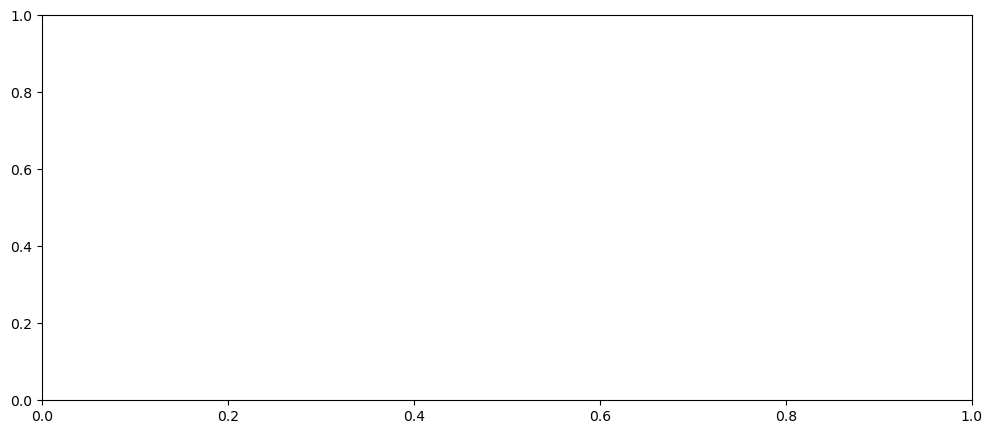

In [9]:

fig, ax = plt.subplots(1,1,figsize=(12,5))  #for barplots yields/excretion
plot_eteTree.plot_tree(t, align_names=False, name_offset=None, max_dist=None, font_size=9, axe=ax,font_size2=8,alternative_names=True,short_names=False)
lc=-1
for level in ["phylum","class","order","family","genus","species"]:
    lc=lc+1
    lpos=0.5+lc*branchdistance_number
    ax.text(lpos,-1.2,level,fontsize=14)
    ax.text(lpos,-2.5,"("+str(round(abundancevalues_sum[lc],1))+"%)",fontsize=14,color='k')

ax.text(6,-4,"taxonomic rank")
fig.tight_layout()
fig.savefig("plot_output_figure1/tree_matplotlib.pdf")
plt.show()

###### old, using eTe3 plotting options

#decide what to add to nodes
def my_layout(node):
        F = TextFace(node.name[:5]) #tight_text=True
        A = TextFace(node.abundance) #, tight_text=True 
        #print(node)
        if node.is_leaf():
            add_face_to_node(F, node, column=1, position="branch-top")
            #add_face_to_node(F, node, column=0,position='aligned')
            add_face_to_node(A, node, column=0,position='aligned')
        else:
            add_face_to_node(F, node, column=0, position="branch-top")
            add_face_to_node(A, node, column=0, position="branch-bottom")

            
            #if node.is_leaf():
        #        seq_face = SeqMotifFace(node.sequence, seqtype='aa', seq_format='seq')
        #        add_face_to_node(seq_face, node, column=0, position='aligned')
    
ts.layout_fn = my_layout

#ts.show_branch_length = True
#ts.show_branch_support = True
#t.render("plot_output_Fig2/tree.pdf", w=8, units="in", tree_style=ts)

#t.show(tree_style=ts)


# Plot compact tree without full names

NameError: name 'plot_eteTree' is not defined

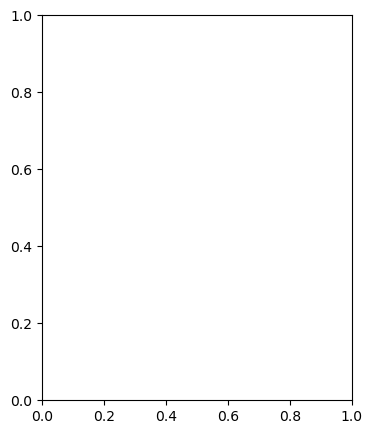

In [15]:
fig, ax = plt.subplots(1,1,figsize=(4,5))  #for barplots yields/excretion
plot_eteTree.plot_tree(t, align_names=False, name_offset=None, max_dist=None, font_size=9, axe=ax,font_size2=8,alternative_names=False,short_names=True,plot_abundancenumbers=True,abundancestyle="plain")
lc=-1
for level in ["phylum","class","order","family","genus","species"]:
    lc=lc+1
    lpos=0.5+lc*branchdistance_number
    
    #ax.text(lpos,-1.5,level,fontsize=10)
    #ax.text(lpos,-2.5,str(round(abundancevalues_sum[lc],1)),fontsize=10,color='k')

ax.text(6,-4,"taxonomic rank")
fig.tight_layout()
fig.savefig("plot_output_figure1/tree_matplotlib_compact.pdf")
plt.show()


# Prepare plots for paper

This script takes data from analysis_out.csv which is generated in the final_analysis notebook. 


In [20]:
###################
#decide what to plot
####################

#use a table with average values  (to generate this table, run Final_analysis_hplcdata.ipynb
dataout_av=pd.read_csv("data_hplc/analysis_out_av.csv")
display(dataout_av.head())
display(speciesinformation.head())

#sort list manually 
sorter=["B.vulgatus","B.fragilis","B.ovatus","B.theta","B.finegoldii","B.uniformis",'P.copri','P.distastonis',"E.rectale","R.intestinalis","F.prausnitzii","R.bromii","B.longum","B.adolescentis","C.aerofaciens","E.coli","E.coliI","E.coliII","Fecal","FecalPP","ECOR","E.halli"]
dataout_av.sort_values(by="species", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)

display(dataout_av)

#speciesall=speciesinformation["species_HPLCname"]
speciesall=["B.vulgatus","B.fragilis","B.ovatus","B.theta","B.finegoldii","B.uniformis",'P.copri','P.distastonis',"E.rectale","R.intestinalis","F.prausnitzii","R.bromii","B.longum","B.adolescentis","C.aerofaciens","E.coli"]

samplenamelist=[[],[],[],[]]
for species in speciesall:
    mc=-1
    for medium in ["e","BHI","simple","YCA"]:
            mc=mc+1
            selectc=dataout_av.loc[(dataout_av["experiment_short"]=="av") & (dataout_av["species"]==species) & (dataout_av["medium"]==medium)]
            #print(selectc)
            for il in range(0,selectc.shape[0]):
                samplenamelist[mc].append(selectc["exp_number"].iloc[il])
print("list output")
for mc in range(0,len(samplenamelist)):
    print(samplenamelist[mc])

print(samplenamelist[3])

sublistshort=['glu','mal','ace','but','for','lac','pro','suc']


#colorlist=['b','b','#1b9e77','#66a61e','#a6761d','#e7298a','#d95f02','#7570b3']


#colorlist = met_brewer.met_brew(name="Egypt", n=8, brew_type="continuous")
#print(colorlist)

colorlist=['#dd5129', '#1e8b99', '#2c7591', '#85635d', '#34a28d', '#fab255', '#acb269', '#5db27d']
#['glucose', 'maltose', 'acetate', 'butyrate', 'formate', 'lactate', 'propionate', 'succinate']
#sublist=['glucose','maltose','acetate','butyrate','formate','lactate','propionate','succinate'] #skipp ethanol here

colorlist=['#dd5129', '#85635d', '#2c7591', '#34a28d', '#fab255','#5db27d', '#1e8b99','#acb269']

sublist=['glucose','maltose','acetate','butyrate','formate','lactate','propionate','succinate'] #skipp ethanol here
print(sublist)

markerlist=['s','h','v','^','<','>','d','o']
energycontent=np.array([0.68,1.36,0.21,0.52,0.,.33,0.37,0.36]) #kcal/mmol #the energy per mm for different fermentation products3
cfactorlist=[6,12,2,4,1,3,3,4]
markerlist=['s','v','^','<','>','d','o','h']
   


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,strain,species,experiment,experiment_short,exp_number,medium,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
0,0,0.0,144.0,NaN,DSM20083,B.adolescentis,NaN,stan_BHI_30Dec35,199,BHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,29.0,NaN,DSM20083,B.adolescentis,analysis_Zur_Newruns_2023_June,m1,33,YCA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.0,45.0,NaN,DSM20083,B.adolescentis,analysis_Zur_Newruns_2023_June,m1,51,YCA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,143.0,NaN,DSM20083,B.adolescentis,NaN,stan_BHI_30Dec34,198,BHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4.0,38.0,NaN,DSM20083,B.adolescentis,analysis_Zur_Newruns_2023_June,m1,42,YCA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,species_HPLCname,species,new_species,species.1,species_short,new_genus,genus,new_family,family,new_order,order,new_class,class,new_phylum,phylum
0,B.vulgatus,Phocaeicola vulgatus,Phocaeicola vulgatus,Bacteroides vulgatus,B. vulgatus,Phocaeicola,Phocaeicola,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes
1,B.fragilis,Bacteroides fragilis,Bacteroides fragilis,Bacteroides fragilis,B. fragilis,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes
2,B.ovatus,Bacteroides ovatus,Bacteroides ovatus,Bacteroides ovatus,B. ovatus,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes
3,B.theta,Bacteroides thetaiotaomicron,Bacteroides thetaiotaomicron,Bacteroides thetaiotaomicron,B. theta,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes
4,P.copri,Prevotella copri,Prevotella copri,Prevotella copri,P. copri,Prevotella,Prevotella,Prevotellaceae,Prevotellaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,strain,species,experiment,experiment_short,exp_number,medium,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
63,63,63.0,92.0,NaN,DSM 1447,B.vulgatus,NaN,analysis_stan_BHI_24Dec22.csv,118,BHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,62,62.0,145.0,NaN,DSM 1447,B.vulgatus,NaN,stan_BHI_30Dec36,200,BHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,64,64.0,118.0,NaN,DSM 1447,B.vulgatus,NaN,analysis_stan_BHI_2.5mM_Feb23.csv,170,BHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,65,65.0,93.0,NaN,DSM 1447,B.vulgatus,NaN,analysis_stan_BHI_24Dec22.csv,119,BHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,66,66.0,128.0,NaN,DSM 1447,B.vulgatus,NaN,stan_YCA_230811_2.5mM,183,YCA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,174,NaN,NaN,NaN,NCM3722,E.coli,"av [146, 112]_used_only: [73.0, 82.0]",av,av_E.coli_NCM3722_gamma,gamma,...,0.172812,0.004613,0.000000,0.898094,NaN,34.978310,0.363957,-10.867657,NaN,0.253183
173,173,NaN,NaN,NaN,NCM3722,E.coli,"av [186, 187, 171]_used_only: [75.0, 76.0, 80.0]",av,av_E.coli_NCM3722_BHI,BHI,...,0.851301,0.055860,0.000000,4.676450,0.062596,19.659161,6.843173,-2.406571,0.166590,0.338551
172,172,NaN,NaN,NaN,NCM3722,E.coli,"av [22, 2, 1]_used_only: [77.0, 78.0, 81.0]",av,av_E.coli_NCM3722_YCA,YCA,...,0.397216,0.461203,0.096961,1.132453,0.000000,21.430628,2.430948,-3.814797,0.058335,0.112149
79,79,79.0,105.0,NaN,NCM3722,E.coli,NaN,analysis_stan_simple.csv,146,gamma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


list output
[]
['av_B.vulgatus_DSM 1447_BHI', 'av_B.fragilis_ATCC25285_BHI', 'av_B.ovatus_ATCC8483_BHI', 'av_B.theta_ATCC29148_BHI', 'av_B.finegoldii_HM-727_BHI', 'av_P.distastonis_HM-169_BHI', 'av_E.rectale_ATCC33656_BHI', 'av_R.intestinalis_DSM14610_BHI', 'av_F.prausnitzii_DSM17677_BHI', 'av_B.longum_DSM20219_BHI', 'av_B.adolescentis_DSM20083_BHI', 'av_C.aerofaciens_DSM3979_BHI', 'av_E.coli_NCM3722_BHI']
[]
['av_B.vulgatus_DSM 1447_YCA', 'av_B.fragilis_ATCC25285_YCA', 'av_B.ovatus_ATCC8483_YCA', 'av_B.theta_ATCC29148_YCA', 'av_B.finegoldii_HM-727_YCA', 'av_B.uniformis_ATCC8492_YCA', 'av_P.copri_DSM18205_YCA', 'av_P.distastonis_HM-169_YCA', 'av_E.rectale_ATCC33656_YCA', 'av_R.intestinalis_DSM14610_YCA', 'av_F.prausnitzii_DSM17677_YCA', 'av_R.bromii_ATCC27255_YCA', 'av_B.longum_DSM20219_YCA', 'av_B.adolescentis_DSM20083_YCA', 'av_C.aerofaciens_DSM3979_YCA', 'av_E.coli_NCM3722_YCA']
['av_B.vulgatus_DSM 1447_YCA', 'av_B.fragilis_ATCC25285_YCA', 'av_B.ovatus_ATCC8483_YCA', 'av_B.theta_ATC

# Plot secrection vs OD - one curve for Fig. 2B.